In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
set_seed(42)

In [3]:
def u(mu,x,y):
    return torch.sin(mu* (x**2)) + torch.sin(mu* (y**2))
def f(mu,x,y):
    term1 = -2 * mu * (torch.cos(mu * x**2) + torch.cos(mu * y**2))
    term2 = 4 * mu**2 * (x**2 * torch.sin(mu * x**2) + y**2 * torch.sin(mu * y**2))
    return term1 + term2

In [4]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales,sigma=1.0,beta=0.1):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        self.M = base_feature_dim * (num_scales + 1)
        base_freqs = torch.randn(self.base_feature_dim, input_dim) * np.pow(sigma,-1)
        all_freqs=[]
        for feature in base_freqs:
            for k in range(0,num_scales+1):
                scale=2.0**k
                all_freqs.append(scale*feature)
        
        omega = torch.stack(all_freqs, dim=0)

        self.register_buffer('omega',omega.reshape(-1,input_dim))
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega.detach().cpu().numpy().flatten()}")
        omega_np = self.omega.detach().cpu().numpy() # 形状: (M, input_dim)
        freq_magnitude = np.linalg.norm(omega_np, axis=1)
        plt.figure(figsize=(10, 6))
        plt.plot(figsize=(10, 6))
        plt.hist(freq_magnitude, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Frequency Magnitude Distribution\nTotal Dim: {self.total_feature_dim}')
        plt.xlabel('Frequency Magnitude (L2 Norm)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi 
        self.register_buffer('phases',phases)
        self.raw_beta=nn.Parameter(torch.log(torch.tensor(beta)))
        self.beta=nn.functional.softplus(self.raw_beta)
    def forward(self, x):
        amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),device=x.device)
        self.scale=torch.sqrt(torch.tensor(1.0/self.total_feature_dim))
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * amplitude
        return features


class CrossAttentionResidualBlock(nn.Module):
    def __init__(self, d_q, num_layers, num_heads):
        super().__init__()
        assert d_q % num_heads == 0, "d_q must be divisible by num_heads"
        self.d_q = d_q
        self.num_layers = num_layers
        self.cross_attn = nn.ModuleList([
            nn.MultiheadAttention(
                embed_dim=d_q,
                num_heads=num_heads,
                dropout=0.0,
                batch_first=True,  
                bias=False
            ) for _ in range(num_layers)
        ])
        
        self.ln1 = nn.ModuleList([nn.LayerNorm(d_q) for _ in range(num_layers)])
        self.ln2 = nn.ModuleList([nn.LayerNorm(d_q) for _ in range(num_layers)])
        
        # FFN 保持不变
        self.ffns = nn.ModuleList([
            nn.Sequential(nn.Linear(d_q, d_q), nn.ReLU())
            for _ in range(num_layers)
        ])
    
    def forward(self, Q, H):
        """
        Args:
            Q: (batch, d_q) 或 (batch, 1, d_q) - Query tokens
            H: (batch, N_tokens, d_q) - Key/Value tokens (RFF features)
        """
        if Q.dim() == 2:
            Q = Q.unsqueeze(1)  # (batch, 1, d_q)
        
        for i in range(self.num_layers):
            # 内置 Cross Attention：Q 作为 query，H 作为 key/value
            # 自动完成：线性投影 → 多头分割 → 缩放 → Softmax → 拼接 → 输出投影
            attn_out, _ = self.cross_attn[i](
                query=Q,           # (batch, 1, d_q)
                key=H,             # (batch, N, d_q)  
                value=H,           # (batch, N, d_q)
                need_weights=False
            )
            
            # 残差连接 1 + LayerNorm
            Q = Q + attn_out
            Q = self.ln1[i](Q)
            
            # FFN + 残差连接 2 + LayerNorm（保持原逻辑）
            ffn_out = self.ffns[i](Q.squeeze(1)).unsqueeze(1)
            Q = Q + ffn_out
            Q = self.ln2[i](Q)
        
        return Q.squeeze(1)


In [5]:
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(True)
class MLP_Network(nn.Module):
    def __init__(self,input_dim,num_layers,width):
        super().__init__()
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
        layers = []
        layers.append(nn.Linear(input_dim, width))
        for _ in range(num_layers - 2):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(width, width))
        layers.append(nn.Linear(width, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

class RFF_CA_Network(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales,
                 d_q, num_layers, num_heads, sigma, beta_init):
        super().__init__()
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
        self.rff = MultiScaleFourierLayer(input_dim, base_feature_dim, num_scales, sigma, beta_init).to(self.device)
        M = self.rff.M
        self.d_q = d_q
        assert M % d_q == 0
        self.N_tok = M // d_q

        self.initial_fc = nn.Sequential(
            nn.Linear(M, d_q),
            nn.ReLU()
        )
        # 共享相同的CA架构
        self.ca_blocks = CrossAttentionResidualBlock(d_q, num_layers, num_heads)
        self.output_layer = nn.Linear(d_q, 1)

    def forward(self, x):
        proj = torch.matmul(x, self.rff.omega.T) + self.rff.phases.unsqueeze(0)  # (B, M_post*d_q)
        scale = torch.sqrt(torch.tensor(1.0 / (self.rff.M * self.d_q), device=x.device))
        phi = torch.cos(proj) * scale
        H = phi.view(x.shape[0], self.N_tok, self.d_q)
        Q_0 = self.rff(x)
        Q = self.initial_fc(Q_0)  # (batch, d_q)
        Q_L = self.ca_blocks(Q, H)        
        return self.output_layer(Q_L)
    
    
class RFF_NN_Network(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales,
                 d_q, num_layers, sigma, beta_init):
        super().__init__()
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
        self.rff = MultiScaleFourierLayer(input_dim, base_feature_dim, num_scales, sigma, beta_init).to(self.device)
        M = self.rff.M
        self.d_q = d_q
        self.initial_fc = nn.Sequential(
            nn.Linear(M, d_q),
            nn.ReLU()
        )
        self.network = nn.Sequential(
            *[layer for _ in range(num_layers - 1) for layer in (nn.Linear(d_q, d_q), nn.ReLU())],
        )
        # 共享相同的CA架构
        self.output_layer = nn.Linear(d_q, 1)

    def forward(self, x):
        Q_0 = self.rff(x)
        Q = self.initial_fc(Q_0)  # (batch, d_q)
        Q_L = self.network(Q)
        return self.output_layer(Q_L)

In [ ]:

class TwoDimPoissonEq(nn.Module):
    def __init__(self, mu, batch_size, alpha=None, use_ca = None):
        super().__init__()
        self.mu = mu
        self.alpha = alpha
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.record_steps = 250
        self.lb = -1.0
        self.ub = 1.0

        self.batch_size = batch_size
        self.x_eval = torch.linspace(self.lb, self.ub, 128).reshape(-1, 1)
        self.y_eval = torch.linspace(self.lb, self.ub, 128).reshape(-1, 1)
        X, Y = torch.meshgrid(self.x_eval.squeeze(), self.y_eval.squeeze())
        self.X_eval = torch.stack([X.flatten(), Y.flatten()], dim=1).to(self.device)
        self.u_eval = u(self.mu, X, Y).flatten().unsqueeze(1).to(self.device)

        self.lb = torch.tensor(self.lb).to(self.device)
        self.ub = torch.tensor(self.ub).to(self.device)

        if use_ca :
            self.u_h = RFF_CA_Network(
                input_dim=2,
                base_feature_dim=512,
                num_scales=2,
                d_q=256,
                num_layers=6,
                num_heads=4,
                sigma=0.07,
                beta_init=0.0
            ).to(self.device)
        elif use_ca == False:
            self.u_h = RFF_NN_Network(
                input_dim=2,
                base_feature_dim=512,
                num_scales=2,
                d_q=256,
                num_layers=6,
                sigma=0.07,
                beta_init=0.0
            ).to(self.device)

        # 低频模型：MLP
        self.u_l = MLP_Network(input_dim=2, num_layers=4, width=64).to(self.device)

        # 可学习的 α 参数
        self.alpha_para = nn.Parameter(torch.tensor(1.0, device=self.device))

        # 优化器
        self.optimizer = torch.optim.AdamW([
            {
                'params': self.u_h.parameters(),
                'lr': 1e-2,
                "weight_decay": 1e-4
            },
                        {
                'params': self.u_l.parameters(),
                'lr': 1e-2,
            },
            {
                'params': self.alpha_para,
                'lr': 1e-3,
            }
        ])

        # 学习率调度器
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=2000,
            gamma=0.5,
        )

        self.lam = 1e4
        self.history = {'alpha': [], 'loss': [], 'error': []}

    def net_u(self, x):
        return self.get_alpha() * self.u_l(x) + self.u_h(x)
    
    def get_alpha(self):
        """mode 取 0, 1, "opt" 或者 learnable """
        if self.alpha == 0:
            return 0.0
        if self.alpha == 1:
            return 1.0
        if self.alpha == "opt":
            # 在内部区域采样点进行最优 α 计算
            x_r = torch.rand(256, 2, device=self.device)  # (N, 2)
            x_r = self.lb + (self.ub - self.lb) * x_r
            x_r.requires_grad_(True)

            N_uh = self.diff_operator(x_r, self.u_h).detach()
            N_ul = self.diff_operator(x_r, self.u_l).detach()

            with torch.no_grad():
                f_xr = f(self.mu, x_r[:, 0], x_r[:, 1])
                numerator = torch.mean((N_uh - f_xr) * N_ul)
                n_per_side = 50
                boundary_points = []
                for fixed_val, axis in [(-1, 1), (1, 1), (-1, 0), (1, 0)]:
                    # 生成随机坐标
                    rand_coords = torch.rand(n_per_side, 2, device=self.device) * 2 - 1
                    # 固定一个坐标
                    rand_coords[:, axis] = fixed_val
                    boundary_points.append(rand_coords)
                numerator = torch.mean((N_uh - f_xr) * N_ul)
                boundary_x = torch.cat(boundary_points, dim=0)
                u_l_boundary = self.u_l(boundary_x)
                denominator = torch.mean(N_ul**2) +self.lam * torch.mean(u_l_boundary**2)
            if abs(denominator.item()) < 1e-10:
                return 0.0
            return - (numerator / denominator).item()

        if self.alpha == "learnable":
            return self.alpha_para
        
    def diff_operator(self, x, model):
        u = model(x)
        # 计算梯度
        grad_u = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u), 
            create_graph=True, 
            retain_graph=True
        )[0]
        
        laplacian = torch.zeros_like(u)
        for i in range(x.shape[1]):
            # 对每个坐标方向计算二阶导数
            grad_ui = grad_u[:, i].view(-1, 1)
            grad_grad_ui = torch.autograd.grad(
                grad_ui, x, 
                grad_outputs=torch.ones_like(grad_ui), 
                create_graph=True, 
                retain_graph=True
            )[0]
            laplacian += grad_grad_ui[:, i].view(-1, 1)
        return - laplacian
    
    def loss(self):
        # 内部点采样
        x_f = torch.rand(self.batch_size, 2, device=self.device)
        x_f = self.lb + (self.ub - self.lb) * x_f
        x_f.requires_grad_(True)
        alpha = self.get_alpha()
        # 计算残差：Δu_h + α Δu_l + f = 0
        residual_h = self.diff_operator(x_f, self.u_h)
        residual_l = self.diff_operator(x_f, self.u_l)
        f_xf = f(self.mu, x_f[:, 0], x_f[:, 1])
        loss_f = torch.mean((residual_h + alpha * residual_l - f_xf)**2)

        # 边界点
        n_per_side = 1000
        boundary_points = []

        # 对于每条边：一个坐标随机，另一个坐标固定
        for fixed_val, axis in [(-1, 1), (1, 1), (-1, 0), (1, 0)]:
            # 生成随机坐标
            rand_coords = torch.rand(n_per_side, 2, device=self.device) * 2 - 1
            # 固定一个坐标
            rand_coords[:, axis] = fixed_val
            boundary_points.append(rand_coords)

        boundary_x = torch.cat(boundary_points, dim=0)
        boundary_u = u(self.mu,boundary_x[:, 0], boundary_x[:, 1])
        pred_u = self.net_u(boundary_x)
        loss_b = self.lam * torch.mean((pred_u - boundary_u)**2)

        if isinstance(alpha, torch.Tensor):
            alpha = alpha.detach().cpu().item()
        else:
            alpha = alpha

        self.history['alpha'].append(alpha)
        return loss_f, loss_b, alpha
    
    def fit(self, nIter):
        self.train()
        for i in range(nIter):
            loss_f, loss_b, alpha = self.loss()

            if i % 100 == 0:
                print(f'Iter {i} | Loss_f: {loss_f.item():.3e}, Loss_b: {loss_b.item():.3e}, Alpha: {alpha:.3f}')

            loss = loss_f + loss_b
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(self.u_h.parameters()), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()


            self.history['loss'].append(loss.item())

            if (i+1) % self.record_steps == 0:
                self.eval()
                u_pred = self.predict(self.X_eval)
                error = np.linalg.norm(u_pred - self.u_eval.cpu().numpy()) / np.linalg.norm(self.u_eval.cpu().numpy())
                self.history['error'].append(error)
                print(f'Iter {i+1}/{nIter} | Relative Error: {error:.3e}')
                self.train()

        self.plot()
        return self.history
    
    def predict(self, x):
        """预测结果"""
        x_tensor = torch.tensor(x).to(self.device)
        alpha = self.get_alpha()
        with torch.no_grad():
            u_pred = alpha * self.u_l(x_tensor) + self.u_h(x_tensor)
        return u_pred.cpu().detach().numpy()
    
    def plot(self):
        plt.figure(figsize=(16, 8))
        epochs = range(0, len(self.history['error']) * self.record_steps, self.record_steps)
        plt.semilogy(epochs, self.history['error'], 'orange', linewidth=2, label='RFF-CA')
        plt.xlabel('Epoch')
        plt.ylabel('Relative $L^2$ Error')
        plt.grid(True, which="both", ls="-", alpha=0.3)
        plt.legend()
        plt.show()

        u_pred = self.predict(self.X_eval)
        u_h_pred = self.u_h(self.X_eval).cpu().detach().numpy()
        u_l_pred = self.u_l(self.X_eval).cpu().detach().numpy()
        alpha = self.get_alpha()
        if isinstance(alpha, torch.Tensor):
            alpha = alpha.detach().cpu().item()
        alpha_u_l = alpha * u_l_pred

        # 重建 2D 网格
        X_grid = self.x_eval.cpu().numpy()
        Y_grid = self.y_eval.cpu().numpy()
        X_mesh, Y_mesh = np.meshgrid(X_grid, Y_grid)
        X_mesh = torch.tensor(X_mesh, device=self.device)
        Y_mesh = torch.tensor(Y_mesh, device=self.device)
        Z_truth = u(self.mu, X_mesh, Y_mesh)
        Z_pred = u_pred.reshape(X_mesh.shape)
        Z_uh = u_h_pred.reshape(X_mesh.shape)
        Z_alpha_ul = alpha_u_l.reshape(X_mesh.shape)
        Z_truth = Z_truth.cpu().numpy()
        Z_error = Z_truth - Z_pred

        fig, axs = plt.subplots(1, 3, figsize=(15,5))
        seaborn_viridis = sns.color_palette("viridis", as_cmap=True)
        seaborn_plasma = sns.color_palette("viridis", as_cmap=True)
        seaborn_coolwarm = sns.color_palette("viridis", as_cmap=True)

        # 左图: uh
        X_mesh = X_mesh.cpu().numpy()
        Y_mesh = Y_mesh.cpu().numpy()
        im1 = axs[0].contourf(X_mesh, Y_mesh, Z_uh, levels=20, cmap=seaborn_viridis, vmin=-4, vmax=4)
        axs[0].set_xlabel('$x_1$')
        axs[0].set_ylabel('$x_2$')
        axs[0].set_title('$u_h$')
        cbar1 = plt.colorbar(im1, ax=axs[0], shrink=0.8)
        cbar1.set_label('Value')

        # 中图: α ul
        im2 = axs[1].contourf(X_mesh, Y_mesh, Z_alpha_ul, levels=20, cmap=seaborn_plasma, vmin=-2.5, vmax=0.5)
        axs[1].set_xlabel('$x_1$')
        axs[1].set_ylabel('$x_2$')
        axs[1].set_title('$\\alpha u_\ell$')
        cbar2 = plt.colorbar(im2, ax=axs[1], shrink=0.8)
        cbar2.set_label('Value')

        # 右图: error
        im3 = axs[2].contourf(X_mesh, Y_mesh, Z_error, levels=20, cmap=seaborn_coolwarm, vmin=-0.15, vmax=0.15)
        axs[2].set_xlabel('$x_1$')
        axs[2].set_ylabel('$x_2$')
        axs[2].set_title('Error (truth - pred)')
        cbar3 = plt.colorbar(im3, ax=axs[2], shrink=0.8)
        cbar3.set_label('Error')

        plt.tight_layout()
        plt.show()

<>:260: SyntaxWarning: invalid escape sequence '\e'
<>:260: SyntaxWarning: invalid escape sequence '\e'
C:\Users\hp\AppData\Local\Temp\ipykernel_6904\764400685.py:260: SyntaxWarning: invalid escape sequence '\e'
  axs[1].set_title('$\\alpha u_\ell$')


Total feature dim=1536. All Fourier feature frequencies:
[  7.717746  12.397623  15.435492 ... -11.558183  66.54584  -23.116365]


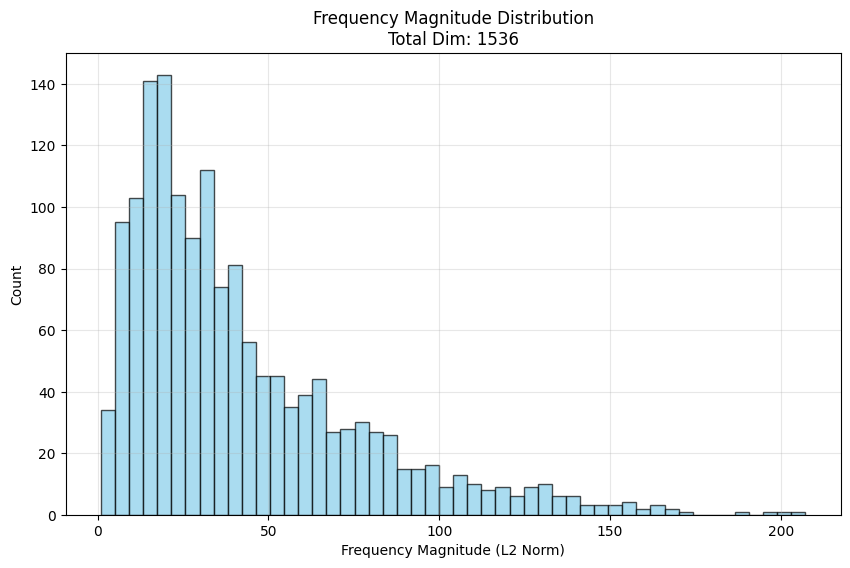

Iter 0 | Loss_f: 1.640e+07, Loss_b: 5.094e+03, Alpha: 1.000


C:\Users\hp\AppData\Local\Temp\ipykernel_6904\638599715.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),device=x.device)
C:\Users\hp\AppData\Local\Temp\ipykernel_6904\764400685.py:260: SyntaxWarning: invalid escape sequence '\e'
  axs[1].set_title('$\\alpha u_\ell$')


KeyboardInterrupt: 

In [26]:
RFF_NN_solver_50 = TwoDimPoissonEq(mu=50.0,batch_size=64,alpha="learnable",use_ca=False)
RFF_NN_history_50 = RFF_NN_solver_50.fit(nIter=1000)

In [ ]:
RFF_CA_solver_50 = TwoDimPoissonEq(mu=50.0,batch_size=64,alpha="learnable",use_ca=True)
RFF_CA_history_50 = RFF_CA_solver_50.fit(nIter=1)

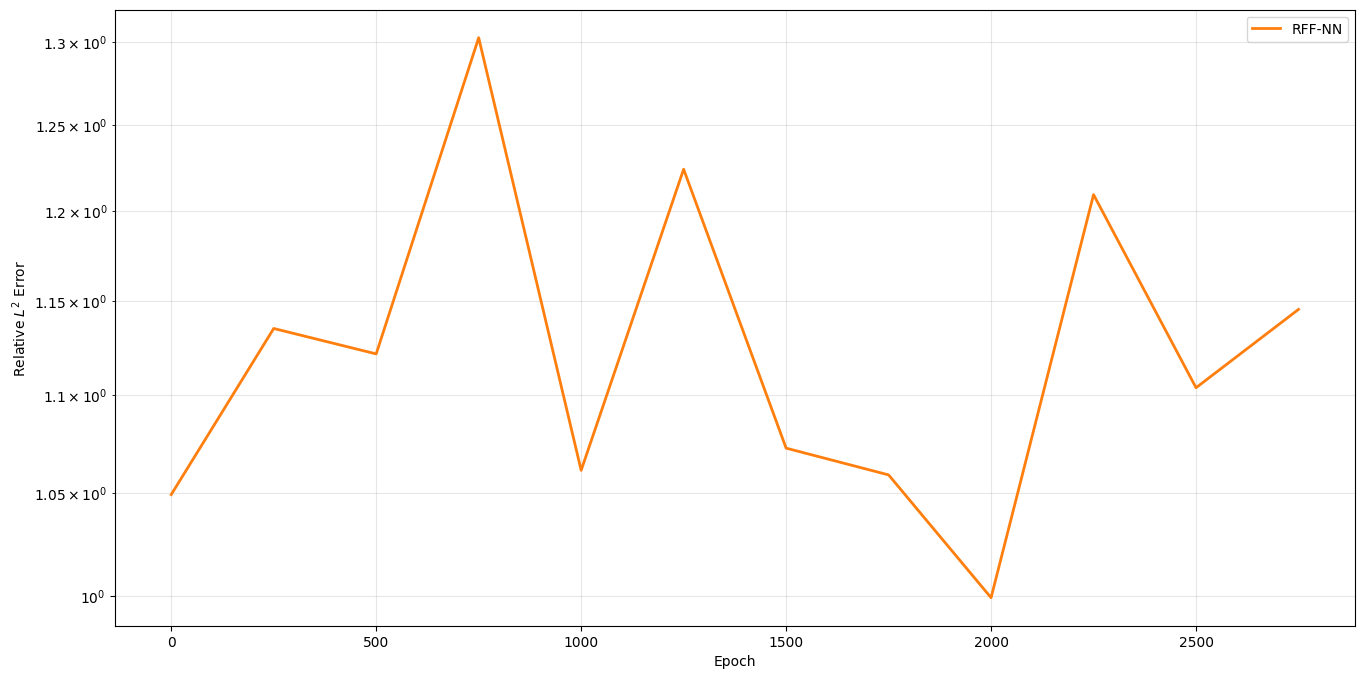

In [ ]:
plt.figure(figsize=(16, 8))
epochs = range(0, len(RFF_NN_history_50['error']) * RFF_NN_solver_50.record_steps, RFF_NN_solver_50.record_steps)
plt.semilogy(epochs, RFF_NN_history_50['error'], 'C0', linewidth=2, label='RFF-NN')
plt.semilogy(epochs, RFF_CA_history_50['error'], 'C1', linewidth=2, label='RFF-CA')

plt.xlabel('Epoch')
plt.ylabel('Relative $L^2$ Error')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()
plt.show()